In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = 'D:/Disease Prediction 2'

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:16<00:00, 154MB/s]
100% 2.29G/2.29G [00:16<00:00, 152MB/s]


In [1]:
import zipfile

z= zipfile.ZipFile('chest-xray-pneumonia.zip')
z.extractall()

In [3]:
import os, shutil
import random
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm, tqdm_notebook
import cv2
from scipy import stats
from sklearn.metrics import confusion_matrix, roc_curve,auc, classification_report, precision_score, recall_score
from sklearn.linear_model import LinearRegression

import skimage
import skimage.segmentation
import copy
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

#%tensorflow_version 2.x
import tensorflow as tf
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

print(tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Flatten, Dense, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.imagenet_utils import decode_predictions

2.16.1


# Loading the dataset

In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))     # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Data Visualization and Preprocessing

In [7]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"

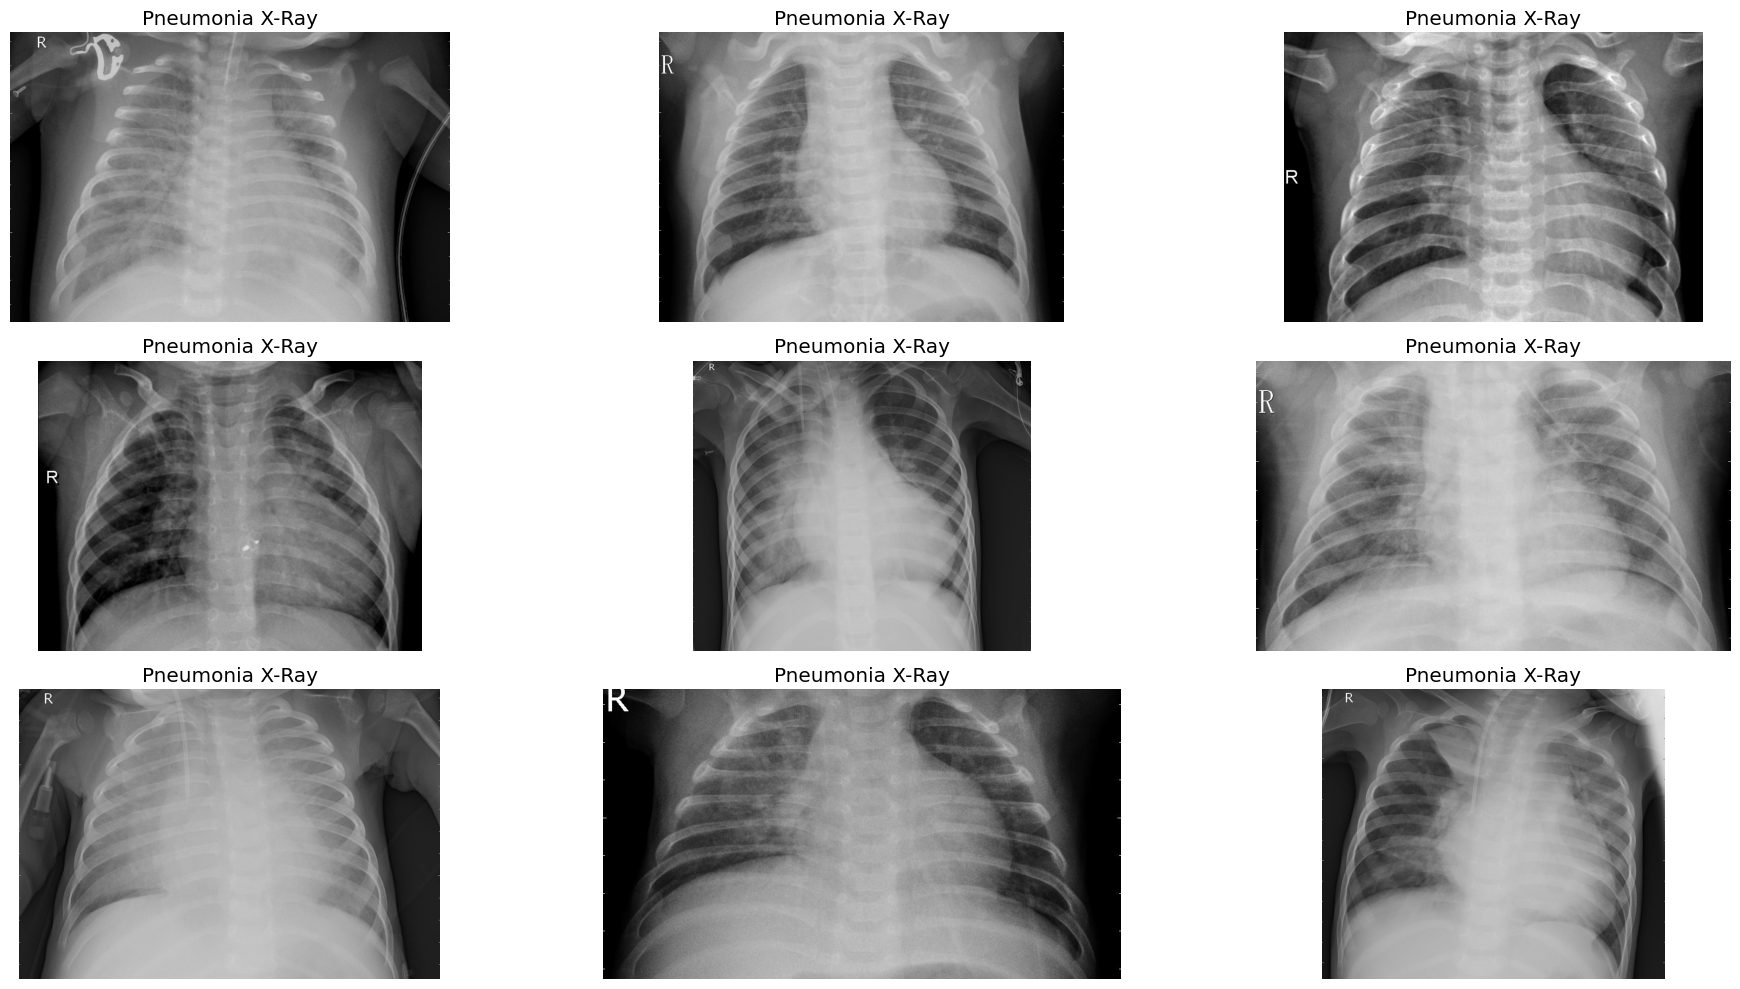

In [9]:
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Pneumonia X-Ray") 
plt.tight_layout()
#plt.savefig("outputs/pneumonia_xray_images.jpeg", format='jpeg', dpi=400, bbox_inches='tight')

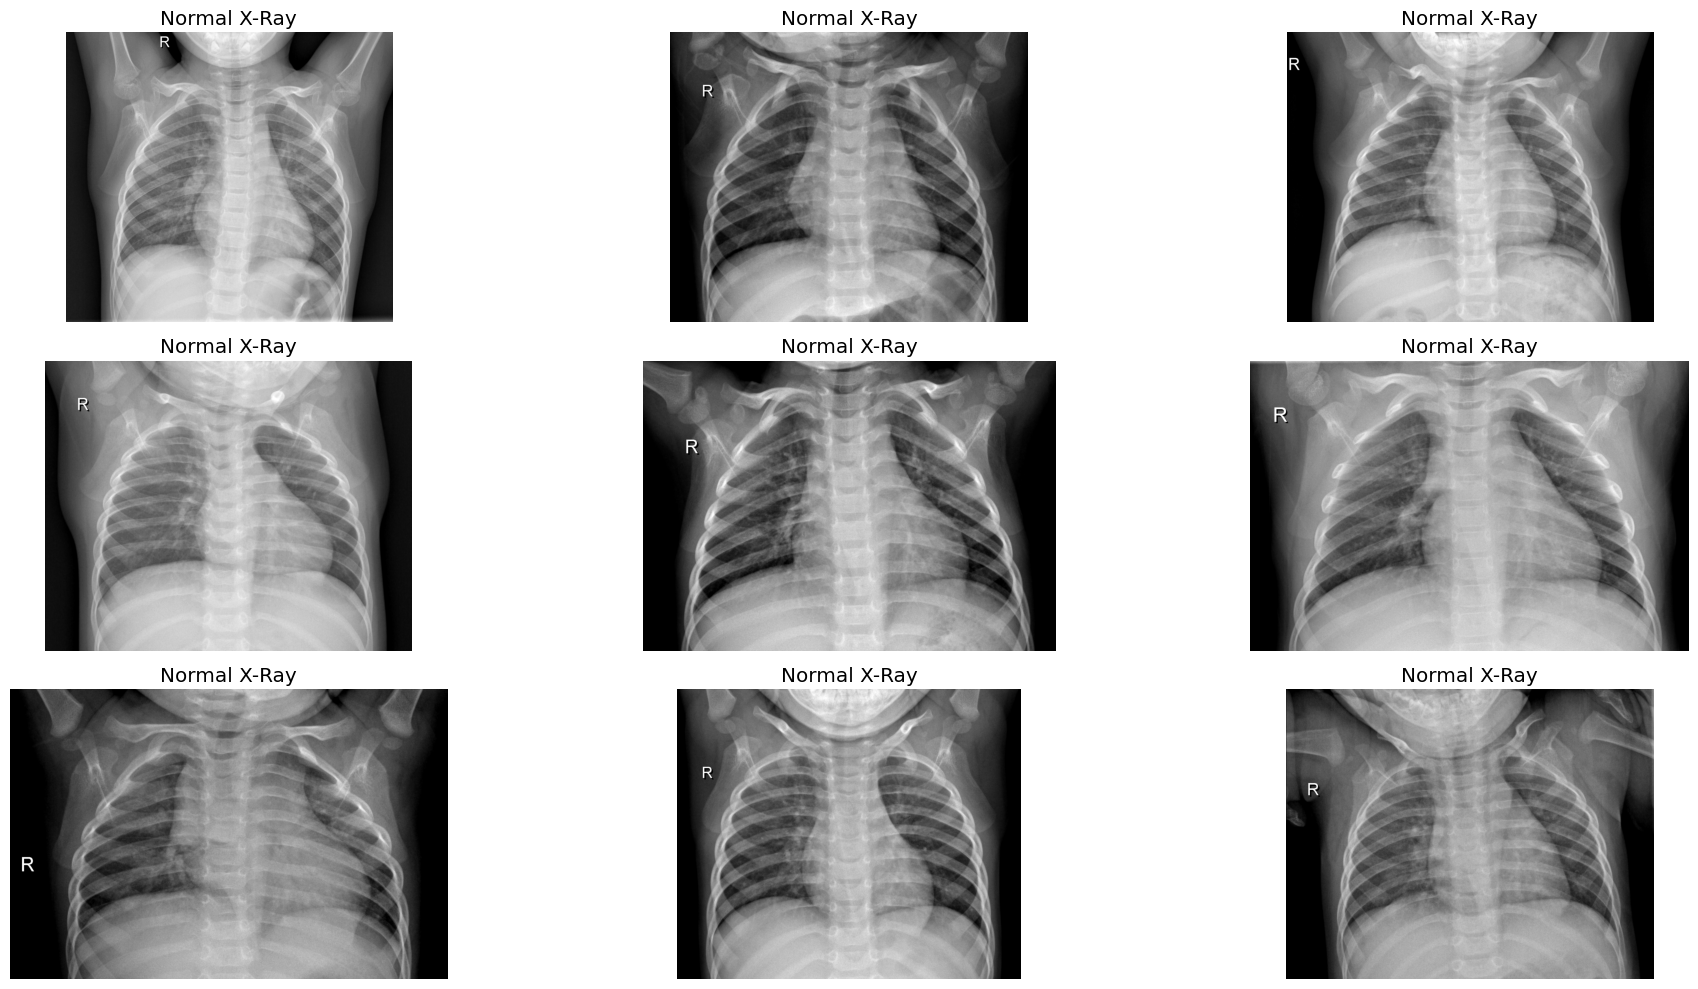

In [10]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Normal X-Ray") 
   
plt.tight_layout()
#plt.savefig("outputs/normal_xray_images.jpeg", format='jpeg', dpi=400, bbox_inches='tight')

In [11]:
train_dir = "chest_xray/train/"
test_dir = "chest_xray/test/"
valid_dir = "chest_xray/val/"


normal_train = os.listdir("chest_xray/train/NORMAL")
normal_train_dir = "chest_xray/train/NORMAL"
normal_val = os.listdir("chest_xray/val/NORMAL")
normal_val_dir = "chest_xray/val/NORMAL"
normal_test = os.listdir("chest_xray/test/NORMAL")
normal_test_dir = "chest_xray/test/NORMAL"

pneumonia_train = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_train_dir = "chest_xray/train/PNEUMONIA"
pneumonia_val = os.listdir("chest_xray/val/PNEUMONIA")
pneumonia_val_dir = "chest_xray/val/PNEUMONIA"
pneumonia_test = os.listdir("chest_xray/test/PNEUMONIA")
pneumonia_test_dir = "chest_xray/test/PNEUMONIA"

In [12]:
print("{} Infected training images:".format(len(os.listdir(pneumonia_train_dir))))
print("{} Normal training images:".format(len(os.listdir(normal_train_dir))))
print(" {} Infected valid images:".format(len(os.listdir(pneumonia_val_dir))))
print(" {} Normal valid images:".format(len(os.listdir(normal_val_dir))))
print(" {} Infected testing images:".format(len(os.listdir(pneumonia_test_dir))))
print(" {} Normal testing images:".format(len(os.listdir(normal_test_dir))))

3875 Infected training images:
1341 Normal training images:
 8 Infected valid images:
 8 Normal valid images:
 390 Infected testing images:
 234 Normal testing images:


In [13]:
# Train
infected_trn_fpaths = [os.path.join(pneumonia_train_dir, fpath) for fpath in os.listdir(pneumonia_train_dir)]
healthy_trn_fpaths = [os.path.join(normal_train_dir, fpath) for fpath in os.listdir(normal_train_dir)]

# Valid
infected_valid_fpaths = [os.path.join(pneumonia_val_dir, fpath) for fpath in os.listdir(pneumonia_val_dir)]
healthy_valid_fpaths = [os.path.join(normal_val_dir, fpath) for fpath in os.listdir(normal_val_dir)]

# Test
infected_test_fpaths = [os.path.join(pneumonia_test_dir, fpath) for fpath in os.listdir(pneumonia_test_dir)]
healthy_test_fpaths = [os.path.join(normal_test_dir, fpath) for fpath in os.listdir(normal_test_dir)]

In [14]:
def get_img_shape(idx, img, total_num_images):
    
    if idx%2000 ==0 or idx == (total_num_images-1):
        print("working on img {}".format(idx))
    return cv2.imread(img).shape

data_inp = [(idx, img, len(infected_trn_fpaths + healthy_trn_fpaths)) for idx, img in enumerate(infected_trn_fpaths + healthy_trn_fpaths)]

train_img_dims_map = list(map(get_img_shape, [input[0] for input in data_inp],
    [input[1] for input in data_inp],
    [input[2] for input in data_inp]))

working on img 0
working on img 2000
working on img 4000
working on img 5215


In [15]:
print('Min Dimensions:           {}'.format(np.min(train_img_dims_map, axis=0)))
print('Avg Dimensions:           {}'.format(np.mean(train_img_dims_map, axis=0)))
print('Median Dimensions:        {}'.format(np.median(train_img_dims_map, axis=0)))
print('Most Frequent Dimensions: {}'.format(stats.mode(train_img_dims_map, axis=0)[0]))
print('Max Dimensions:           {}'.format(np.max(train_img_dims_map, axis=0)))

Min Dimensions:           [127 384   3]
Avg Dimensions:           [ 968.07476994 1320.61081288    3.        ]
Median Dimensions:        [ 888. 1284.    3.]
Most Frequent Dimensions: [ 736 1008    3]
Max Dimensions:           [2663 2916    3]


In [16]:
infected_trn_samples = random.sample(infected_trn_fpaths, 5)
healthy_trn_samples = random.sample(healthy_trn_fpaths, 5)

# Data augmentation and resizing images

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=0.4,
                                   vertical_flip=0.4,
                                   rotation_range=40,
                                   shear_range=0.2,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    target_size=(128,128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    batch_size=32,
                                                    target_size=(128, 128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

class_labels = train_generator.class_indices
class_names = {value:key for (key, value) in class_labels.items()}

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [18]:
class_labels, class_names

({'NORMAL': 0, 'PNEUMONIA': 1}, {0: 'NORMAL', 1: 'PNEUMONIA'})

# Transfer Learning - VGG19 CNN Architecture

In [20]:
# Instantiate VGG19 model with weights from Imagenet without the calssifier at the top
base_model = VGG19(input_shape = (128,128,3),
                   include_top = False, 
                   weights = 'imagenet')
# Freeze the ConvNet to avoid weight updates
for layer in base_model.layers:
    layer.trainable=False
    
x = base_model.output
flat=Flatten()(x)

# Add a classifier -  a fully connected dense layers
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

# Bake a model
model_01 = Model(base_model.inputs, output)
model_01.summary()

# Call backs
filepath = 'Model/pneumonia.keras'
es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.0001)

# Define an optimizer
sgd = SGD(learning_rate=.0001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

C:\Users\lloyd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [21]:
# Fit the model on the training set and train for 10 epochs
history_01 = model_01.fit(train_generator,
                          steps_per_epoch=50,
                          epochs=20,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator)

Epoch 1/20


C:\Users\lloyd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7772 - loss: 0.5399
Epoch 1: val_loss improved from inf to 0.68519, saving model to Model/pneumonia.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7766 - loss: 0.5400 - val_accuracy: 0.5000 - val_loss: 0.6852 - learning_rate: 1.0000e-04
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7658 - loss: 0.4821
Epoch 2: val_loss improved from 0.68519 to 0.60620, saving model to Model/pneumonia.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.7656 - loss: 0.4821 - val_accuracy: 0.5625 - val_loss: 0.6062 - learning_rate: 1.0000e-04
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7877 - loss: 0.4365
Epoch 3: val_loss improved from 0.60620 to 0.59143, saving model to Model/pneumonia.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.7878 - loss: 0.4365 - val_accuracy: 0.5625 - val_loss: 0.5914 - learning_rate: 1.0000e-04
Epoch 4/20
13/50 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.769

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 4: val_loss improved from 0.59143 to 0.58681, saving model to Model/pneumonia.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7818 - loss: 0.4169 - val_accuracy: 0.5625 - val_loss: 0.5868 - learning_rate: 1.0000e-04
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8235 - loss: 0.4028
Epoch 5: val_loss improved from 0.58681 to 0.57134, saving model to Model/pneumonia.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8232 - loss: 0.4028 - val_accuracy: 0.6250 - val_loss: 0.5713 - learning_rate: 1.0000e-04
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8081 - loss: 0.4023
Epoch 6: val_loss did not improve from 0.57134
50/50 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8083 - loss: 0.4020 - val_accuracy: 0.5625 - val_loss: 0.5885 - learning_rate: 1.0000e-04
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8203 - loss: 0.3949
Epoch 7: val_loss improved from 0.57134 to 0.51984, saving model to Model/pneumonia.keras
5

In [24]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_01.save_weights(filepath='model_weights/vgg19_model_01pneumonia.weights.h5', overwrite=True)

In [25]:
# Resize test images similar to the train data
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                  target_size=(128, 128),
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  seed=42,
                                                  color_mode='rgb')

Found 624 images belonging to 2 classes.


In [26]:
# Load the saved model
model_01.load_weights('model_weights/vgg19_model_01pneumonia.weights.h5')
# Evaluate the model on the hold out validation and test datasets

# Evaluate the model on batches of validation and testing data
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

print('Validation loss:     {0:.4f}'.format(vgg_val_eval_01[0]))
print('Validation accuracy: {0:.4f}'.format(vgg_val_eval_01[1]))
print('Test loss:           {0:.4f}'.format(vgg_test_eval_01[0]))
print('Test accuracy:       {0:.4f}'.format(vgg_test_eval_01[1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6250 - loss: 0.6458


C:\Users\lloyd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


624/624 ━━━━━━━━━━━━━━━━━━━━ 95s 152ms/step - accuracy: 0.5053 - loss: 0.8180
Validation loss:     0.6458
Validation accuracy: 0.6250
Test loss:           0.5115
Test accuracy:       0.7308


In [27]:
filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_01 = model_01.predict(test_generator,
                                      steps = nb_samples,
                                      verbose=1)
vgg_pred_labels_01= np.argmax(vgg_predictions_01, axis=1)

624/624 ━━━━━━━━━━━━━━━━━━━━ 92s 147ms/step


In [28]:
# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_01, 
                            target_names=['NORMAL', 'PNEUMONIA']))
vgg_conf_mat_01 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_01), 
                        index=['NORMAL', 'PNEUMONIA'], 
                        columns=['NORMAL', 'PNEUMONIA'])

              precision    recall  f1-score   support

      NORMAL       0.93      0.30      0.46       234
   PNEUMONIA       0.70      0.99      0.82       390

    accuracy                           0.73       624
   macro avg       0.82      0.65      0.64       624
weighted avg       0.79      0.73      0.68       624



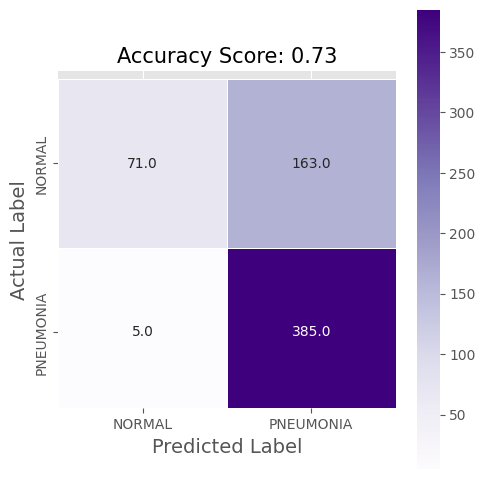

In [29]:
fig, ax = plt.subplots(figsize=(5,5))
#plt.figure(figsize=(9,9))
sns.heatmap(vgg_conf_mat_01, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_01[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_01)-0.05, -0.05)
plt.tight_layout()

# Incremental unfreezing and fine-tuning

In [30]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output

flat=Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01pneumonia.weights.h5')

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv4', 'block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 47,784,834 (182.28 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

None


In [31]:
sgd = SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
#model_02 = Model(base_model.inputs, output)
model_02.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

C:\Users\lloyd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [32]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs=10, callbacks = [es, cp, lrr], validation_data = valid_generator)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8216 - loss: 0.3510
Epoch 1: val_loss improved from 0.51984 to 0.43696, saving model to Model/pneumonia.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.8217 - loss: 0.3516 - val_accuracy: 0.7500 - val_loss: 0.4370 - learning_rate: 0.0010
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8608 - loss: 0.3693
Epoch 2: val_loss improved from 0.43696 to 0.43372, saving model to Model/pneumonia.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.8601 - loss: 0.3681 - val_accuracy: 0.8125 - val_loss: 0.4337 - learning_rate: 0.0010
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8117 - loss: 0.4697
Epoch 3: val_loss did not improve from 0.43372
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8109 - loss: 0.4694 - val_accuracy: 0.6250 - val_loss: 0.6028 - learning_rate: 0.0010
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8675 - loss: 0.3017
Epoch 4: val_loss did no

In [33]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath='model_weights/vgg19_model_02pneumonia.weights.h5', overwrite=True)

# Evaluating the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step - accuracy: 0.5625 - loss: 0.8893
624/624 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.5357 - loss: 0.9487
Validation loss:     0.8893153071403503
Validation accuracy: 0.5625
Test loss:           0.5531438589096069
Test accuracy:       0.7483974099159241
624/624 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step
              precision    recall  f1-score   support

     healthy       1.00      0.33      0.50       234
    infected       0.71      1.00      0.83       390

    accuracy                           0.75       624
   macro avg       0.86      0.66      0.66       624
weighted avg       0.82      0.75      0.71       624



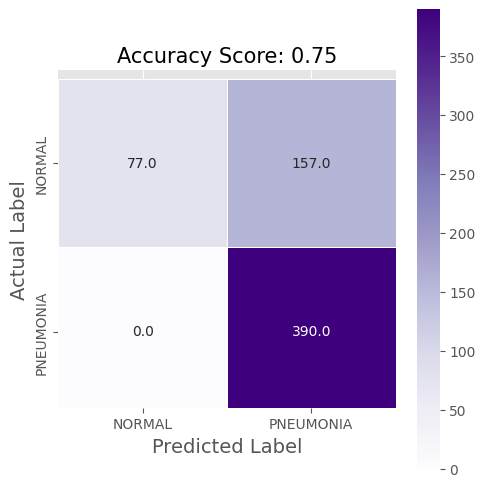

In [34]:
# Load the saved model
model_02.load_weights('model_weights/vgg19_model_02pneumonia.weights.h5')
# Evaluate the model on the hold out validation and test datasets

vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print('Validation loss:     {}'.format(vgg_val_eval_02[0]))
print('Validation accuracy: {}'.format(vgg_val_eval_02[1]))
print('Test loss:           {}'.format(vgg_test_eval_02[0]))
print('Test accuracy:       {}'.format(vgg_test_eval_02[1]))


filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_02 = model_02.predict(test_generator,
                                                steps = nb_samples,
                                                verbose=1)
vgg_pred_labels_02 = np.argmax(vgg_predictions_02, axis=1)


# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_02, 
                            target_names=['healthy', 'infected']))
vgg_conf_mat_02 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_02), 
                        index=['NORMAL', 'PNEUMONIA'], 
                        columns=['NORMAL', 'PNEUMONIA'])


fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(vgg_conf_mat_02, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_02[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_02)-0.05, -0.05)
plt.tight_layout()

# Unfreezing and fine-tuning the entire network

In [35]:
# Build the network
base_model = VGG19(include_top=False, input_shape=(128,128,3))
x = base_model.output
flat=Flatten()(x)
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)
model_03 = Model(base_model.inputs, output)

# Load weights
model_03.load_weights('model_weights/vgg19_model_02pneumonia.weights.h5')

sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
# Compile the model
model_03.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\lloyd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [36]:
history_03 = model_03.fit(train_generator,
                          steps_per_epoch=100,
                          epochs=35,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator)

Epoch 1/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8886 - loss: 0.2668
Epoch 1: val_loss did not improve from 0.43372
100/100 ━━━━━━━━━━━━━━━━━━━━ 419s 4s/step - accuracy: 0.8886 - loss: 0.2667 - val_accuracy: 0.6875 - val_loss: 0.6273 - learning_rate: 1.0000e-04
Epoch 2/35
 63/100 ━━━━━━━━━━━━━━━━━━━━ 2:24 4s/step - accuracy: 0.9088 - loss: 0.2116

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.43372 to 0.37094, saving model to Model/pneumonia.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.9100 - loss: 0.2100 - val_accuracy: 0.8125 - val_loss: 0.3709 - learning_rate: 1.0000e-04
Epoch 3/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9285 - loss: 0.1900
Epoch 3: val_loss did not improve from 0.37094
100/100 ━━━━━━━━━━━━━━━━━━━━ 395s 4s/step - accuracy: 0.9284 - loss: 0.1899 - val_accuracy: 0.6875 - val_loss: 0.6105 - learning_rate: 1.0000e-04
Epoch 4/35
 63/100 ━━━━━━━━━━━━━━━━━━━━ 2:25 4s/step - accuracy: 0.9356 - loss: 0.1683
Epoch 4: val_loss improved from 0.37094 to 0.27512, saving model to Model/pneumonia.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.9350 - loss: 0.1664 - val_accuracy: 0.8125 - val_loss: 0.2751 - learning_rate: 1.0000e-04
Epoch 5/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9392 - loss: 0.1491
Epoch 5: val_loss did not improve from 0.27512
100/100 ━━━━━━━━━━━━━━━━━━━━ 3

In [37]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_03.save_weights(filepath='model_weights/vgg_unfrozen_pneumonia.weights.h5', overwrite=True)

# Evaluating the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step - accuracy: 0.9375 - loss: 0.1843
624/624 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.8572 - loss: 0.4605
Validation loss     :0.1843
Validation accuracy :0.9375
Test loss           :0.3010
Test accuracy       :0.9022
624/624 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step
              precision    recall  f1-score   support

     healthy       0.95      0.78      0.86       234
    infected       0.88      0.98      0.93       390

    accuracy                           0.90       624
   macro avg       0.92      0.88      0.89       624
weighted avg       0.91      0.90      0.90       624



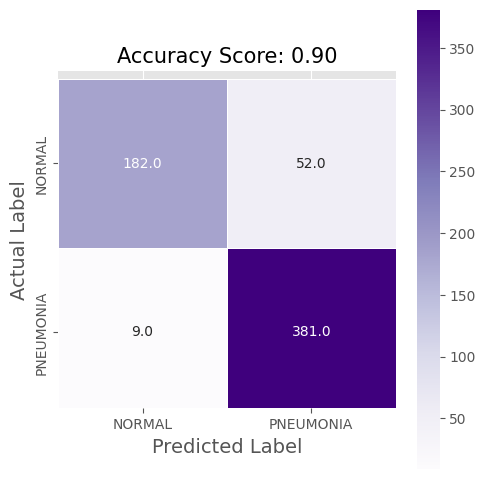

In [38]:
# Load the saved model
model_03.load_weights('model_weights/vgg_unfrozen_pneumonia.weights.h5')
# Evaluate the model on the hold out validation and test datasets

vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

print('Validation loss     :{0:.4f}'.format(vgg_val_eval_03[0]))
print('Validation accuracy :{0:.4f}'.format(vgg_val_eval_03[1]))
print('Test loss           :{0:.4f}'.format(vgg_test_eval_03[0]))
print('Test accuracy       :{0:.4f}'.format(vgg_test_eval_03[1]))


filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_03 = model_03.predict(test_generator,
                                      steps = nb_samples,
                                      verbose=1)
vgg_pred_labels_03 = np.argmax(vgg_predictions_03, axis=1)


# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_03, 
                            target_names=['healthy', 'infected']))
vgg_conf_mat_03 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_03), 
                        index=['NORMAL', 'PNEUMONIA'], 
                        columns=['NORMAL', 'PNEUMONIA'])


fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(vgg_conf_mat_03, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_03[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_03)-0.05, -0.05)
plt.tight_layout()

# Prediction results for 10 randomly selected images

In [61]:
test_images = [img for img in random.sample(infected_trn_fpaths, 2)]
test_images.extend([img for img in random.sample(healthy_trn_fpaths, 2)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


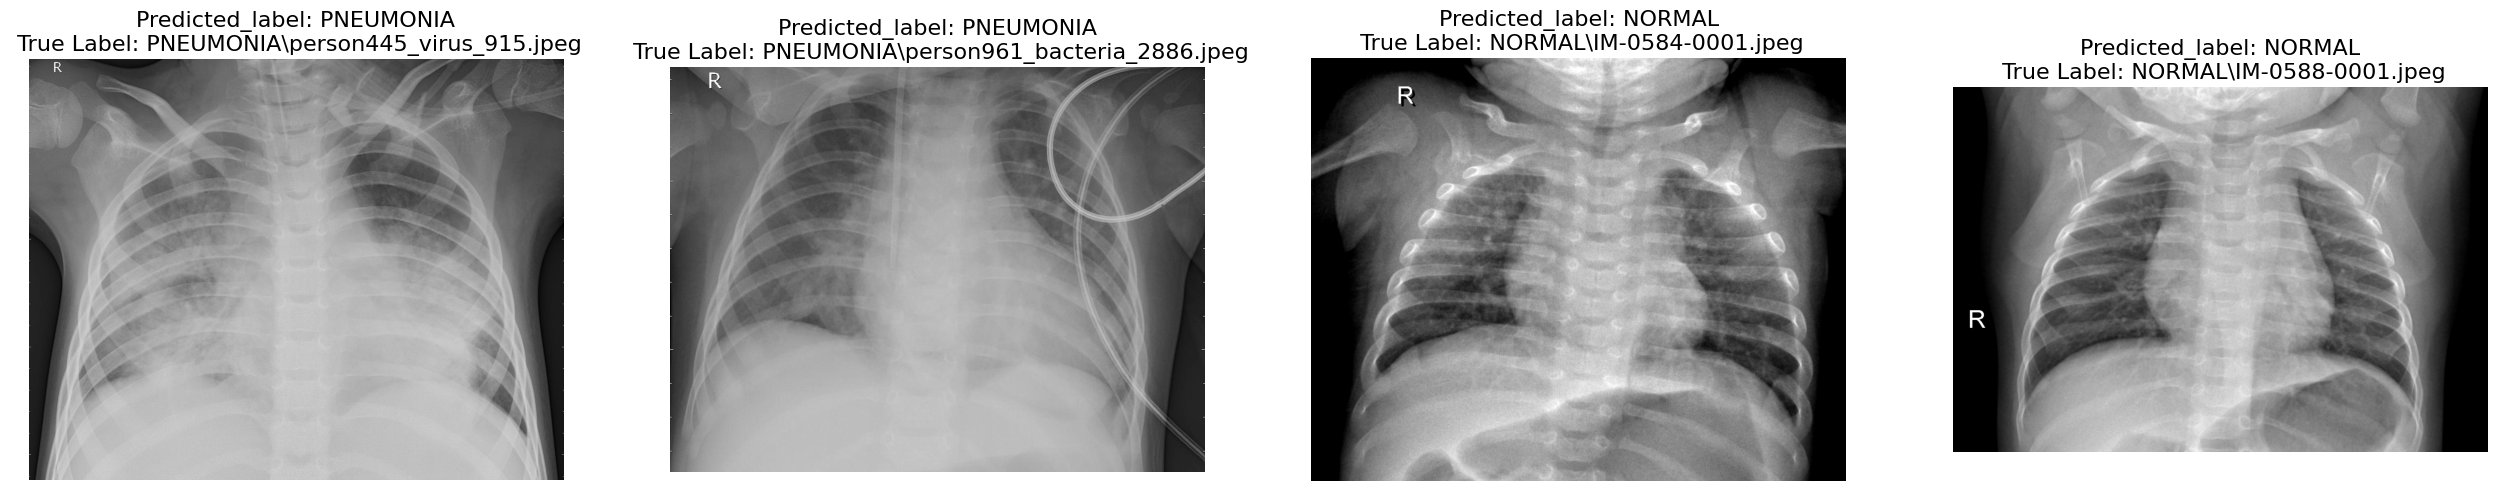

In [62]:
true_labels = []
predicted_labels = [] 

fig = plt.figure(figsize=(40, 20))
columns = 5
rows = 2

total_plots = columns * rows
num_images = min(len(test_images), total_plots)  # Ensure we don't exceed the available images

for i in range(1, num_images + 1):
    fig.add_subplot(rows, columns, i)
    true_label = true_labels.append(test_images[i-1].split('/')[2])
    img = mpimg.imread(test_images[i-1])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    img = tf.keras.utils.load_img(test_images[i-1], target_size=(128, 128))
    img = tf.keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    prediction = model_03.predict(img)
    predicted_label = np.argmax(prediction)
    plt.title('Predicted_label: {}\n True Label: {}'.format(class_names[predicted_label], true_labels[i-1]), fontsize=16)

plt.show()